In [1]:
import os
import pickle
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde

In [2]:
def scatter_plot(x, y, xlabel, ylabel, title):
    g = sns.JointGrid()
    sns.scatterplot(x=x, y=y, ax=g.ax_joint) # can set s=10
    sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x) 
    sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y)

    g.ax_joint.set(xlabel=xlabel, ylabel=ylabel)

    g.ax_joint.plot([np.min(x), np.max(x)], [np.min(x), np.max(x)], linewidth=1.0, color='black', linestyle='solid', label='Equality Line')

    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b

    g.ax_joint.plot(x2, y2, 'r--', linewidth=3.0, label='Linear Regression Line')
    g.ax_joint.legend()
    
    pearson_correlation = pearsonr(x,y)[0]

    g.ax_joint.text(np.max(x), np.min(y)+0.05*np.abs(np.min(y2)), 'R='+str(round(pearson_correlation,3)), horizontalalignment='right', fontsize='large')
    print("Reg Slope:", w)

    g.fig.suptitle(title, y=1.05)

    plt.show()

def scatter_plot_heatmap(x, y, xlabel, ylabel, title, equality_line=True, set_scale=False):
    
    x = x.to_numpy()
    y = y.to_numpy()
    
    fig = plt.figure(figsize=[7.2, 7.2])
    sns.set_style("darkgrid", {'image.cmap': u'plasma'})
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x,y,c=z,s=50)
    if equality_line == True:
        plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality
    
    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b
    plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')
    
    pearson_correlation = pearsonr(x,y)[0]
#     plt.text(np.max(x), np.min(y)+0.05*np.abs(np.min(y2)), 'R='+str(round(pearson_correlation,3)), horizontalalignment='right', fontsize='large')
    
    if set_scale == True:
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        c_min, c_max = min(x_min, y_min), max(x_max, y_max)
        plt.xlim([c_min-2, c_max+2])
        plt.ylim([c_min-2, c_max+2])
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    lbl = 'Pearson R = '+str(round(pearson_correlation,3))
    plt.plot([],[],' ',label=lbl)
    
    plt.title(title)
    plt.legend()
    plt.show()
    
    
def get_corr_plot(array, title, labels, partial_correlation=False, fig_size=None, fix_colorbar_scale=False):
    with sns.axes_style("white"):
        if fig_size == None:
            fig = plt.figure() # can set figsize=(fig_size = 12.8, fig_size)
        else:
            fig = plt.figure(figsize=(fig_size, fig_size))
        ax = fig.add_subplot(111)
        if fix_colorbar_scale == True:
            cax = ax.matshow(array, interpolation='nearest',cmap='viridis', vmin=0, vmax=1)
        else:
            cax = ax.matshow(array, interpolation='nearest',cmap='viridis')
        fig.colorbar(cax)
        if partial_correlation == False:
            intro = "Pearson R"
        else:
            intro = "Partial Correlation"
        plt.title("{} for {}".format(intro, title), fontsize=fig_size+5 if fig_size != None else 10)
        ax.set_yticks(np.arange(len(labels)))
        ax.set_yticklabels(labels)
        ax.xaxis.set_ticks_position("bottom")
        ax.set_xticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=90)
        plt.show()

def correlation_plot(df, key, title, partial_correlation= False, fig_size=None, fix_colorbar_scale=False):
    
    names = df.modality.to_list()
    
    if partial_correlation == False:
        corr_df1 = []
        for idx1 in range(len(df)):
            df1 = df.iloc[idx1].dataframe
            corr_df2 = []
            for idx2 in range(len(df)):
                df2 = df.iloc[idx2].dataframe
                r, _ = pearsonr(df1[key], df2[key])
                corr_df2.append(r)
            corr_df2 = np.array(corr_df2).astype('float32')
            corr_df1.append(corr_df2)
        corr_df1 = np.array(corr_df1).astype('float32')
        get_corr_plot(corr_df1, labels=names, partial_correlation=partial_correlation,
                      title=title, fig_size=fig_size, fix_colorbar_scale=fix_colorbar_scale) 
    else:
        tmp_dct = {}
        for idx in range(len(df)):
            tmp_df = df.iloc[idx].dataframe[key]
            tmp_dct[names[idx]] = tmp_df.to_numpy()
        pcorr_df = pd.DataFrame.from_dict(tmp_dct)
        del tmp_dct, tmp_df
        
        # This implementation comes from https://pingouin-stats.org/index.html
        # Source code here for pcorr: https://github.com/raphaelvallat/pingouin/blob/72e447d539f8cfbd6b9c9c5041e267de748fe124/pingouin/correlation.py

        V = pcorr_df.cov()
        Vi = np.linalg.pinv(V, hermitian=True)
        D = np.diag(np.sqrt(1 / np.diag(Vi)))
        pcor = -1 * (D @ Vi @ D)
        pcor[np.diag_indices_from(pcor)] = 1
        get_corr_plot(pcor, labels=names, partial_correlation=partial_correlation,
                      title=title, fig_size=fig_size, fix_colorbar_scale=fix_colorbar_scale) 
        
def kde_plot(x, y, xlabel, ylabel, title):
    plt.figure()
    sns.kdeplot(x, label='Ground Truth')
    sns.kdeplot(y, label= ylabel)
    plt.legend()
    plt.title(title)

In [3]:
# df = pd.read_pickle('female_test_prototype.pkl')
# df = pd.read_pickle('female_train.pkl')
# df = pd.read_pickle('female_testA.pkl')
df = pd.read_pickle('female_test_testB_convergence.pkl')

In [4]:
df.iloc[0].dataframe

,Unnamed: 0,target_age,output_age_1,age_delta_1,loss_1,output_age_2,age_delta_2,loss_2,output_age_3,age_delta_3,...,output_age_11,age_delta_11,loss_11,output_age_12,age_delta_12,loss_12,mean_output_age,mean_age_delta,output_age_decon,age_delta_decon
0,24237795,77.280940,78.818400,1.537460,2.363784,77.248090,-0.032845,0.001079,73.003700,-4.277237,...,77.247360,-0.033577,0.001127,76.558600,-0.722336,0.521769,76.702871,-0.578069,79.095214,1.814274
1,25463415,58.056694,59.786156,1.729462,2.991038,59.988520,1.931828,3.731958,58.892105,0.835411,...,61.786896,3.730202,13.914405,60.963684,2.906990,8.450591,59.964648,1.907954,59.323598,1.266904
2,25313661,59.653084,60.252045,0.598961,0.358754,60.983814,1.330730,1.770844,59.957380,0.304295,...,58.906757,-0.746326,0.557003,58.852480,-0.800602,0.640964,59.057751,-0.595333,58.252348,-1.400736
3,23521455,53.088700,53.661730,0.573032,0.328366,52.227220,-0.861481,0.742149,52.315693,-0.773006,...,53.320477,0.231777,0.053721,53.252693,0.163994,0.026894,53.644980,0.556280,51.858645,-1.230055
4,25206481,50.428654,52.374870,1.946217,3.787759,50.241924,-0.186729,0.034868,50.706787,0.278133,...,49.858765,-0.569889,0.324774,51.515700,1.087048,1.181672,51.111459,0.682805,48.865985,-1.562669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2505,25785977,55.227055,60.966366,5.739311,32.939693,60.906292,5.679237,32.253740,61.868473,6.641419,...,60.250730,5.023674,25.237300,61.218050,5.990994,35.892002,60.621263,5.394208,60.099209,4.872154
2506,25068363,61.883446,62.464890,0.581444,0.338077,63.891790,2.008343,4.033441,63.060158,1.176712,...,64.291534,2.408089,5.798891,61.402992,-0.480453,0.230836,62.942078,1.058632,62.840615,0.957169
2507,22834218,60.501940,59.926830,-0.575111,0.330753,59.652700,-0.849243,0.721214,65.956245,5.454304,...,61.521700,1.019760,1.039911,61.064130,0.562187,0.316054,60.946204,0.444264,60.483038,-0.018902
2508,24442683,56.130707,54.165280,-1.965427,3.862905,53.800680,-2.330029,5.429033,54.390842,-1.739864,...,53.483154,-2.647553,7.009534,52.648895,-3.481812,12.123012,53.876329,-2.254378,52.131920,-3.998787


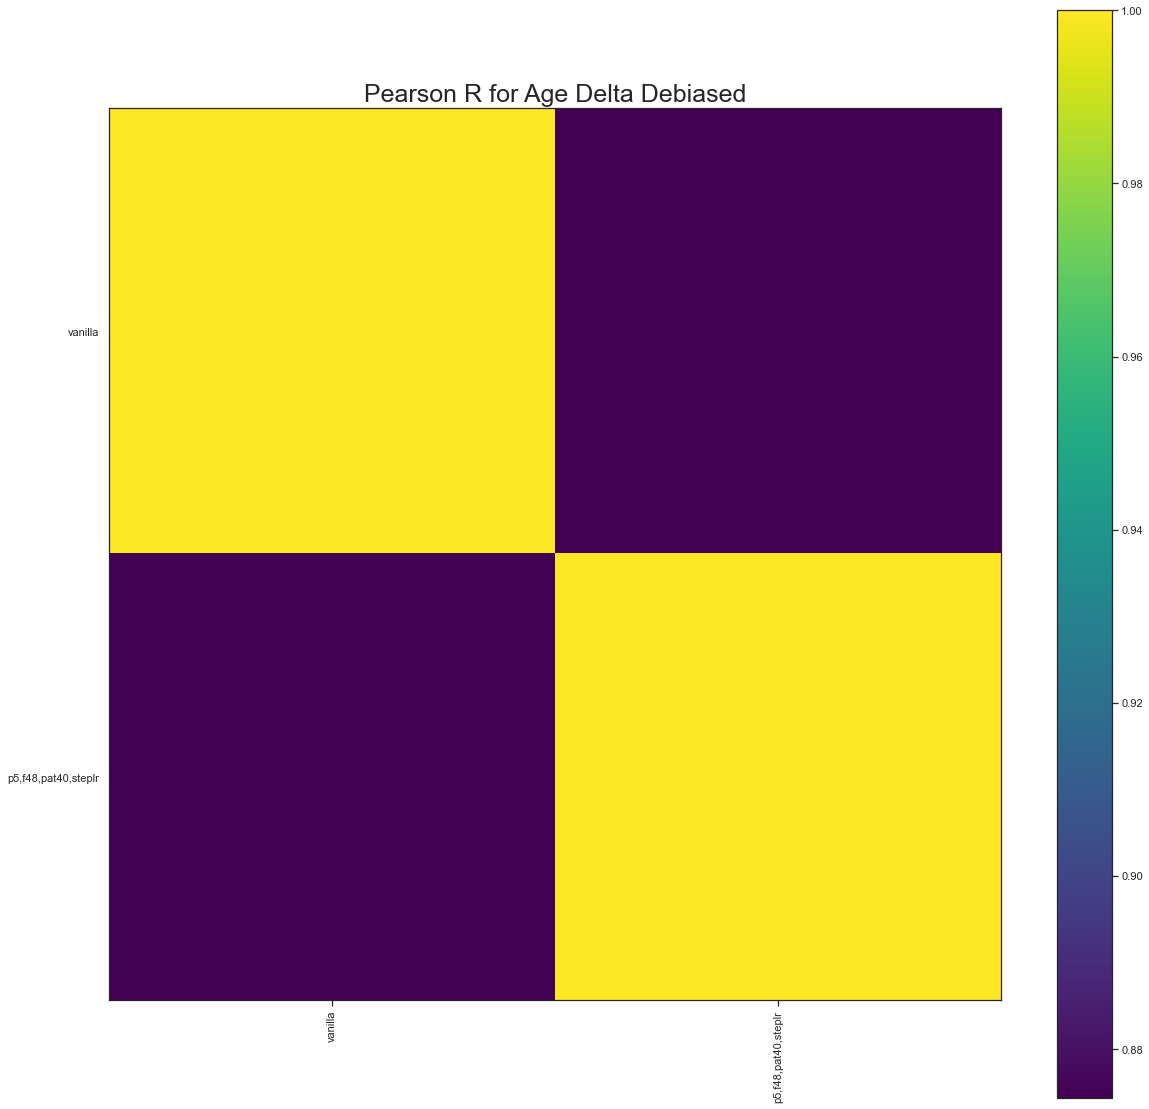

In [5]:
# # correlation_plot(df, key='mean_output_age', title='Mean Output Age', fig_size=20)
# # correlation_plot(df, key='mean_age_delta', title='Mean Age Delta', fig_size=20)
# # correlation_plot(df, key='output_age_decon', title='Output Age Deconfounded', fig_size=20)
# correlation_plot(df, key='age_delta_decon', title='Age Delta Debiased', 
#                  partial_correlation=False, fig_size=20)
# # correlation_plot(df, key='age_delta_decon', title='Age Delta Deconfounded', fig_size=20, 
# #                  partial_correlation=False, fix_colorbar_scale=True)

# correlation_plot(df, key='mean_output_age', title='Mean Output Age', fig_size=20)
# correlation_plot(df, key='mean_age_delta', title='Mean Age Delta', fig_size=20)
# correlation_plot(df, key='output_age_decon', title='Output Age Deconfounded', fig_size=20)
correlation_plot(df, key='age_delta_decon', title='Age Delta Debiased', 
                 partial_correlation=False, fig_size=20)
# correlation_plot(df, key='age_delta_decon', title='Age Delta Deconfounded', fig_size=20, 
#                  partial_correlation=False, fix_colorbar_scale=True)

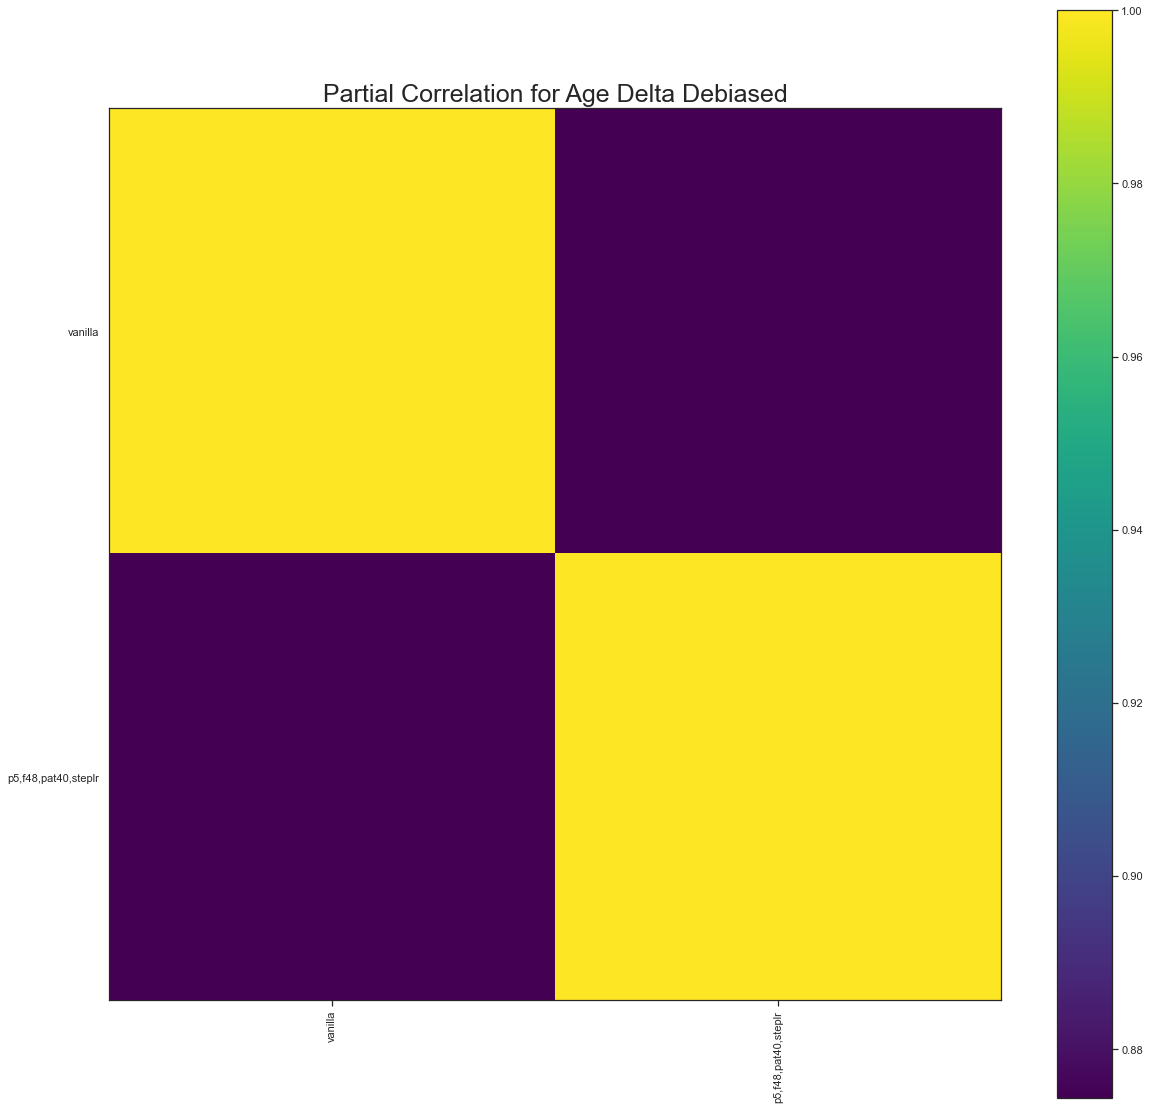

In [6]:
correlation_plot(df, key='age_delta_decon', title='Age Delta Debiased', 
                 partial_correlation=True, fig_size=20)
# correlation_plot(df, key='age_delta_decon', title='Age Delta Deconfounded', fig_size=20, 
#                  partial_correlation=True, fix_colorbar_scale=True)

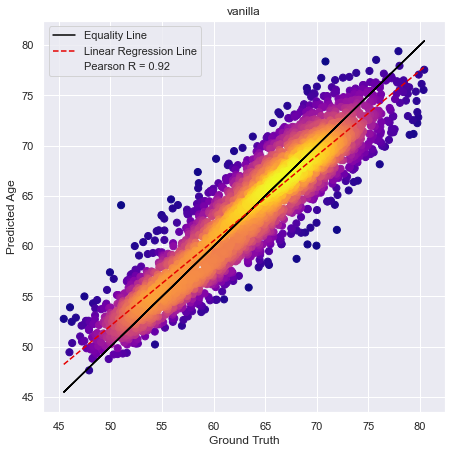

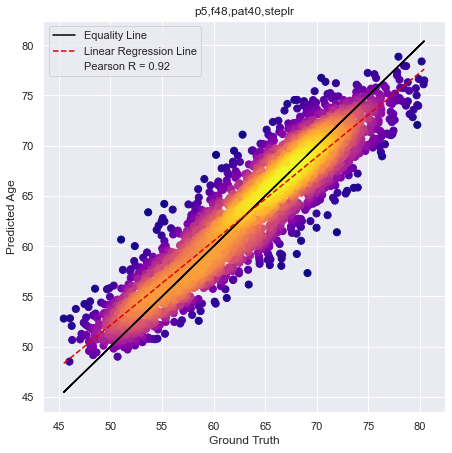

In [8]:
for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod.mean_output_age, xlabel='Ground Truth', 
                               ylabel='Predicted Age', title=name_mod, set_scale=True)

# for idx in range(len(df)):
#     df_mod = df.iloc[idx].dataframe
#     name_mod = df.iloc[idx].modality
#     fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod.output_age, xlabel='Ground Truth', 
#                                ylabel='Predicted Age', title=name_mod, set_scale=True)

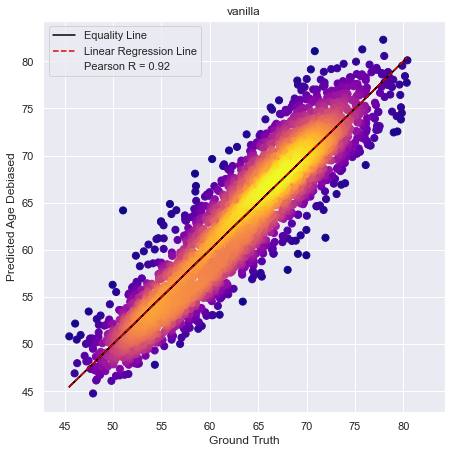

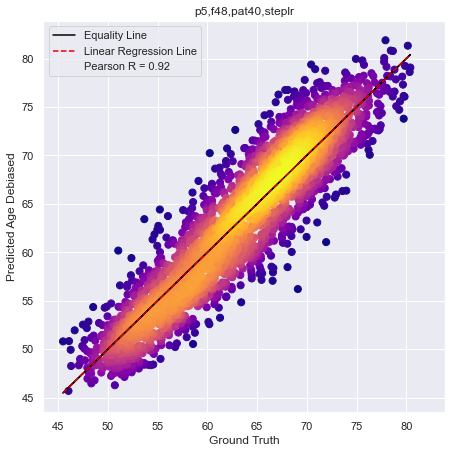

In [9]:
for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod.output_age_decon, xlabel='Ground Truth', 
                               ylabel='Predicted Age Debiased', title=name_mod, set_scale=True)

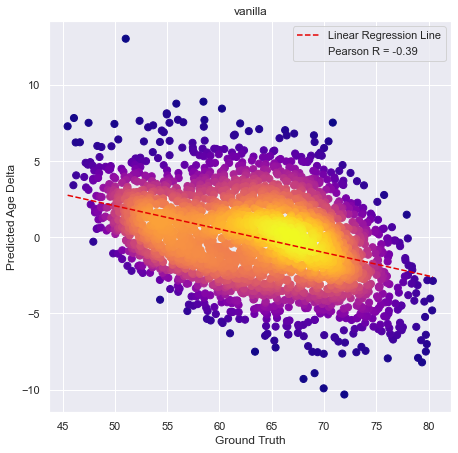

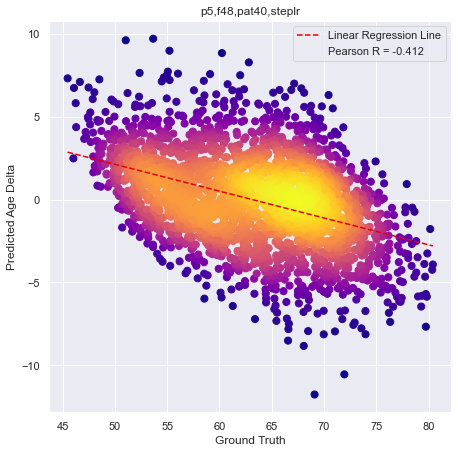

In [10]:
for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod.mean_age_delta, xlabel='Ground Truth', 
                               ylabel='Predicted Age Delta', title=name_mod, set_scale=False, 
                               equality_line=False)

# for idx in range(len(df)):
#     df_mod = df.iloc[idx].dataframe
#     name_mod = df.iloc[idx].modality
#     fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod.age_delta, xlabel='Ground Truth', 
#                                ylabel='Predicted Age Delta', title=name_mod, set_scale=False, 
#                                equality_line=False)

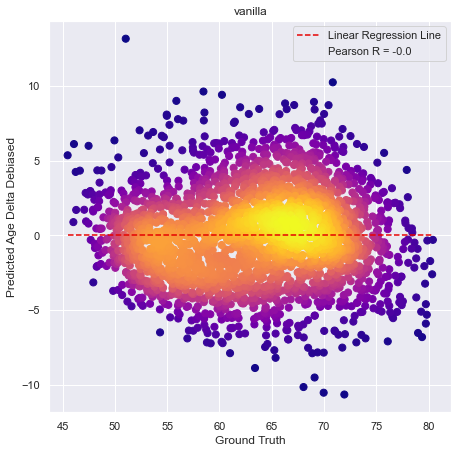

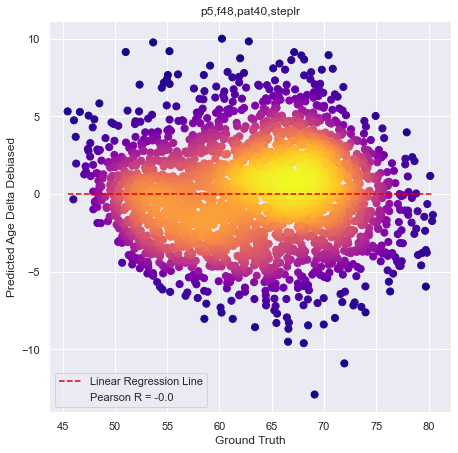

In [11]:
for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    fig = scatter_plot_heatmap(x=df_mod.target_age, y=df_mod.age_delta_decon, xlabel='Ground Truth', 
                               ylabel='Predicted Age Delta Debiased', title=name_mod, set_scale=False, 
                               equality_line=False)

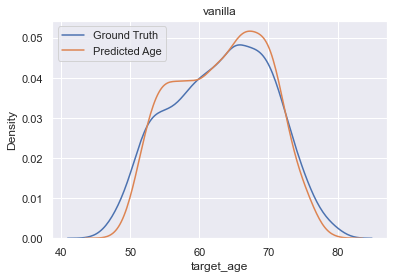

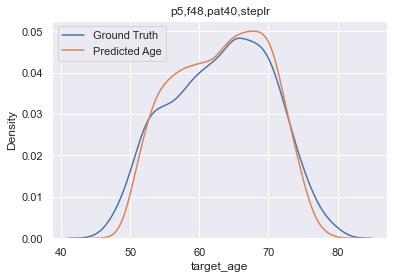

In [12]:
for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    fig = kde_plot(x=df_mod.target_age, y=df_mod.mean_output_age, 
                   xlabel='Ground Truth', ylabel='Predicted Age',
                   title=name_mod)
# for idx in range(len(df)):
#     df_mod = df.iloc[idx].dataframe
#     name_mod = df.iloc[idx].modality
#     fig = kde_plot(x=df_mod.target_age, y=df_mod.output_age, 
#                    xlabel='Ground Truth', ylabel='Predicted Age',
#                    title=name_mod)

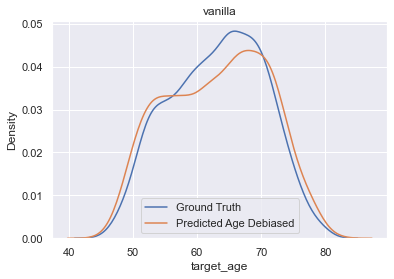

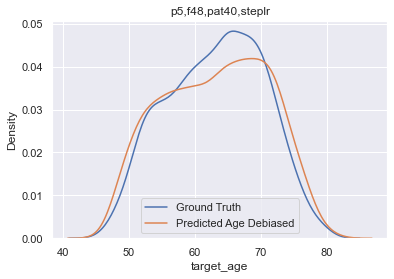

In [13]:
for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    fig = kde_plot(x=df_mod.target_age, y=df_mod.output_age_decon, 
                   xlabel='Ground Truth', ylabel='Predicted Age Debiased',
                   title=name_mod)

In [16]:
df

,modality,dataframe
0,vanilla,Unnamed: 0 target_age output_age_1 ag...
1,"p5,f48,pat40,steplr",Unnamed: 0 target_age output_age_1 ag...


In [20]:
!ls '../../multi-age-mapper/Analysis Female - Variance Study/female_test_testB_convergence.pkl'

../../multi-age-mapper/Analysis Female - Variance Study/female_test_testB_convergence.pkl


In [48]:
df2 = pd.read_pickle("../../multi-age-mapper/Analysis Female - Variance Study/female_test_testB_convergence.pkl")

In [49]:
df2 = df2.drop(index=[1,2])

In [50]:
df2

,modality,dataframe
0,T1_nonlinear,Unnamed: 0 target_age output_age_1 ag...


In [46]:
# df2 = df2.reindex([3])

In [52]:
df3 = pd.concat([df2, df])
df3

,modality,dataframe
0,T1_nonlinear,Unnamed: 0 target_age output_age_1 ag...
0,vanilla,Unnamed: 0 target_age output_age_1 ag...
1,"p5,f48,pat40,steplr",Unnamed: 0 target_age output_age_1 ag...


In [54]:
dfcopy = df
df = df3

In [55]:
df

,modality,dataframe
0,T1_nonlinear,Unnamed: 0 target_age output_age_1 ag...
0,vanilla,Unnamed: 0 target_age output_age_1 ag...
1,"p5,f48,pat40,steplr",Unnamed: 0 target_age output_age_1 ag...


In [34]:
df3

,modality,dataframe
0,vanilla,Unnamed: 0 target_age output_age_1 ag...
1,"p5,f48,pat40,steplr",Unnamed: 0 target_age output_age_1 ag...


In [14]:
def scatter_plot(x, y, xlabel, ylabel, title):
    g = sns.JointGrid()
    sns.scatterplot(x=x, y=y, ax=g.ax_joint) # can set s=10
    sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x) 
    sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y)

    g.ax_joint.set(xlabel=xlabel, ylabel=ylabel)

    g.ax_joint.plot([np.min(x), np.max(x)], [np.min(x), np.max(x)], linewidth=1.0, color='black', linestyle='solid', label='Equality Line')

    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b

    g.ax_joint.plot(x2, y2, 'r--', linewidth=3.0, label='Linear Regression Line')
    g.ax_joint.legend()
    
    pearson_correlation = pearsonr(x,y)[0]

    g.ax_joint.text(np.max(x), np.min(y)+0.05*np.abs(np.min(y2)), 'R='+str(round(pearson_correlation,3)), horizontalalignment='right', fontsize='large')
    print("Reg Slope:", w)

    g.fig.suptitle(title, y=1.05)

    plt.show()

def scatter_plot_heatmap(x, y, xlabel, ylabel, title, equality_line=True, set_scale=False):
    
    x = x.to_numpy()
    y = y.to_numpy()
    
    fig = plt.figure(figsize=[7.2, 7.2])
    sns.set_style("darkgrid", {'image.cmap': u'plasma'})
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x,y,c=z,s=50)
    if equality_line == True:
        plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality
    
    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b
    plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')
    
    pearson_correlation = pearsonr(x,y)[0]
#     plt.text(np.max(x), np.min(y)+0.05*np.abs(np.min(y2)), 'R='+str(round(pearson_correlation,3)), horizontalalignment='right', fontsize='large')
    
    if set_scale == True:
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        c_min, c_max = min(x_min, y_min), max(x_max, y_max)
        plt.xlim([c_min-2, c_max+2])
        plt.ylim([c_min-2, c_max+2])
    
    plt.xlabel(xlabel,  fontsize=15)
    plt.ylabel(ylabel,  fontsize=15)
    
    lbl = 'Pearson R = '+str(round(pearson_correlation,3))
    plt.plot([],[],' ',label=lbl)
    
    plt.title(title, fontsize=15)
    plt.legend(fontsize=12)
    plt.show()
    
    return fig


def scatter_plot_heatmap_subplots(ax, x, y, xlabel, ylabel, title, equality_line=True, set_scale=False,
                                 set_y_scale=None, set_hard_scale=None, 
                                  title_font_size=15, x_axis_off_flag=False, y_axis_off_flag=False,
                                  ticks_font_size=12,
                                  plot_legend_flag = True, legend_font = 12, plot_full_legend=True,
                                  text_x=40, text_y=40,
                                 ):
    
    x = x.to_numpy()
    y = y.to_numpy()
    
    sns.set_style("darkgrid", {'image.cmap': u'plasma'})
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    srt = z.argsort()
    x, y, z = x[srt], y[srt], z[srt]
    ax.scatter(x,y,c=z,s=50)
    if equality_line == True:
        if plot_full_legend==True:
            ax.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality
        else:
            ax.plot(x, x, ls="-", color = sns.xkcd_rgb['black']) #this is just the line of equality


    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b
    if plot_full_legend==True:
        ax.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')
    else:
        ax.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'])
    
    pearson_correlation = pearsonr(x,y)[0]
    
    if set_scale == True:
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        c_min, c_max = min(x_min, y_min), max(x_max, y_max)
        ax.set_xlim([c_min-2, c_max+2])
        ax.set_ylim([c_min-2, c_max+2])
        
    if set_y_scale != None:
        ax.set_ylim([-set_y_scale-2, set_y_scale+2])
        
    if set_hard_scale!=None:
        ax.set_xlim([set_hard_scale[0]-2, set_hard_scale[1]+2])
        ax.set_ylim([set_hard_scale[2]-2, set_hard_scale[3]+2])
    
    ax.set_xlabel(xlabel,  fontsize=title_font_size)
    ax.set_ylabel(ylabel,  fontsize=title_font_size)
    
    ax.tick_params(axis='x', labelsize= ticks_font_size)
    ax.tick_params(axis='y', labelsize= ticks_font_size)
    
    lbl = 'Pearson R = '+str(round(pearson_correlation,3))
#     ax.plot([],[],' ',label=lbl)
    ax.text(text_x, text_y, lbl, fontsize=legend_font)
    
    ax.set_title(title, fontsize=title_font_size)
    if plot_legend_flag == True:
        ax.legend(fontsize=legend_font, loc=2)
    
    if x_axis_off_flag == True:
        ax.axes.xaxis.set_ticklabels([])
    if y_axis_off_flag == True:
        ax.axes.yaxis.set_ticklabels([])
    
def get_corr_plot(array, title, labels, partial_correlation=False, fig_size=None, fix_colorbar_scale=False):
    with sns.axes_style("white"):
        if fig_size == None:
            fig = plt.figure() # can set figsize=(fig_size = 12.8, fig_size)
        else:
            fig = plt.figure(figsize=(fig_size, fig_size))
        ax = fig.add_subplot(111)
        if fix_colorbar_scale == True:
            cax = ax.matshow(array, interpolation='nearest',cmap='viridis', vmin=0, vmax=1)
        else:
            cax = ax.matshow(array, interpolation='nearest',cmap='viridis')
        fig.colorbar(cax)
        if partial_correlation == False:
            intro = "Pearson R"
        else:
            intro = "Partial Correlation"
        plt.title("{} for {}".format(intro, title), fontsize=fig_size+5 if fig_size != None else 10)
        ax.set_yticks(np.arange(len(labels)))
        ax.set_yticklabels(labels)
        ax.xaxis.set_ticks_position("bottom")
        ax.set_xticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=90)
        plt.show()

def correlation_plot(df, key, title, partial_correlation= False, fig_size=None, fix_colorbar_scale=False):
    
    names = df.modality.to_list()
    
    if partial_correlation == False:
        corr_df1 = []
        for idx1 in range(len(df)):
            df1 = df.iloc[idx1].dataframe
            corr_df2 = []
            for idx2 in range(len(df)):
                df2 = df.iloc[idx2].dataframe
                r, _ = pearsonr(df1[key], df2[key])
                corr_df2.append(r)
            corr_df2 = np.array(corr_df2).astype('float32')
            corr_df1.append(corr_df2)
        corr_df1 = np.array(corr_df1).astype('float32')
        get_corr_plot(corr_df1, labels=names, partial_correlation=partial_correlation,
                      title=title, fig_size=fig_size, fix_colorbar_scale=fix_colorbar_scale) 
    else:
        tmp_dct = {}
        for idx in range(len(df)):
            tmp_df = df.iloc[idx].dataframe[key]
            tmp_dct[names[idx]] = tmp_df.to_numpy()
        pcorr_df = pd.DataFrame.from_dict(tmp_dct)
        del tmp_dct, tmp_df
        
        # This implementation comes from https://pingouin-stats.org/index.html
        # Source code here for pcorr: https://github.com/raphaelvallat/pingouin/blob/72e447d539f8cfbd6b9c9c5041e267de748fe124/pingouin/correlation.py

        V = pcorr_df.cov()
        Vi = np.linalg.pinv(V, hermitian=True)
        D = np.diag(np.sqrt(1 / np.diag(Vi)))
        pcor = -1 * (D @ Vi @ D)
        pcor[np.diag_indices_from(pcor)] = 1
        get_corr_plot(pcor, labels=names, partial_correlation=partial_correlation,
                      title=title, fig_size=fig_size, fix_colorbar_scale=fix_colorbar_scale) 
        
def kde_plot(x, y, xlabel, ylabel, title):
    plt.figure()
    sns.kdeplot(x, label='Ground Truth')
    sns.kdeplot(y, label= ylabel)
    plt.legend()
    plt.title(title)
    
def kde_subplot(ax, x, y, xlegend=None, ylegend=None, xlabel=None, ylabel=None, title=None,
               title_font_size=15, x_axis_off_flag=False, y_axis_off_flag=False, set_hard_scale=None,
                ticks_font_size=12, 
                plot_legend_flag = True, legend_font = 12,
               ):
    
    if ylegend == None:
        ylegend = ['Predicted Brain Ages', 'Debiased Predicted Brain Ages']
    
    ax.tick_params(axis='x', labelsize= ticks_font_size)
    ax.tick_params(axis='y', labelsize= ticks_font_size)
    
    sns.kdeplot(x, ax=ax, label= xlegend, color = sns.xkcd_rgb['black'], linewidth = 2)
    if isinstance(y, list):
        for i, ys in enumerate(y):
            sns.kdeplot(ys, ax=ax, label= ylegend[i], linewidth = 2)
    else:
        sns.kdeplot(y, ax=ax, label= ylegend)
    ax.set_xlabel(xlabel,  fontsize=15)
    ax.set_ylabel(ylabel,  fontsize=title_font_size)
    ax.set_title(title, fontsize=title_font_size)
    if plot_legend_flag == True:
        ax.legend(fontsize=legend_font, loc=2)
    if x_axis_off_flag == True:
        ax.axes.xaxis.set_ticklabels([])
    if y_axis_off_flag == True:
        ax.axes.yaxis.set_ticklabels([])
    if set_hard_scale!=None:
        ax.set_xlim([set_hard_scale[0]-2, set_hard_scale[1]+2])
        ax.set_ylim([set_hard_scale[2]-0.001, set_hard_scale[3]+0.001])


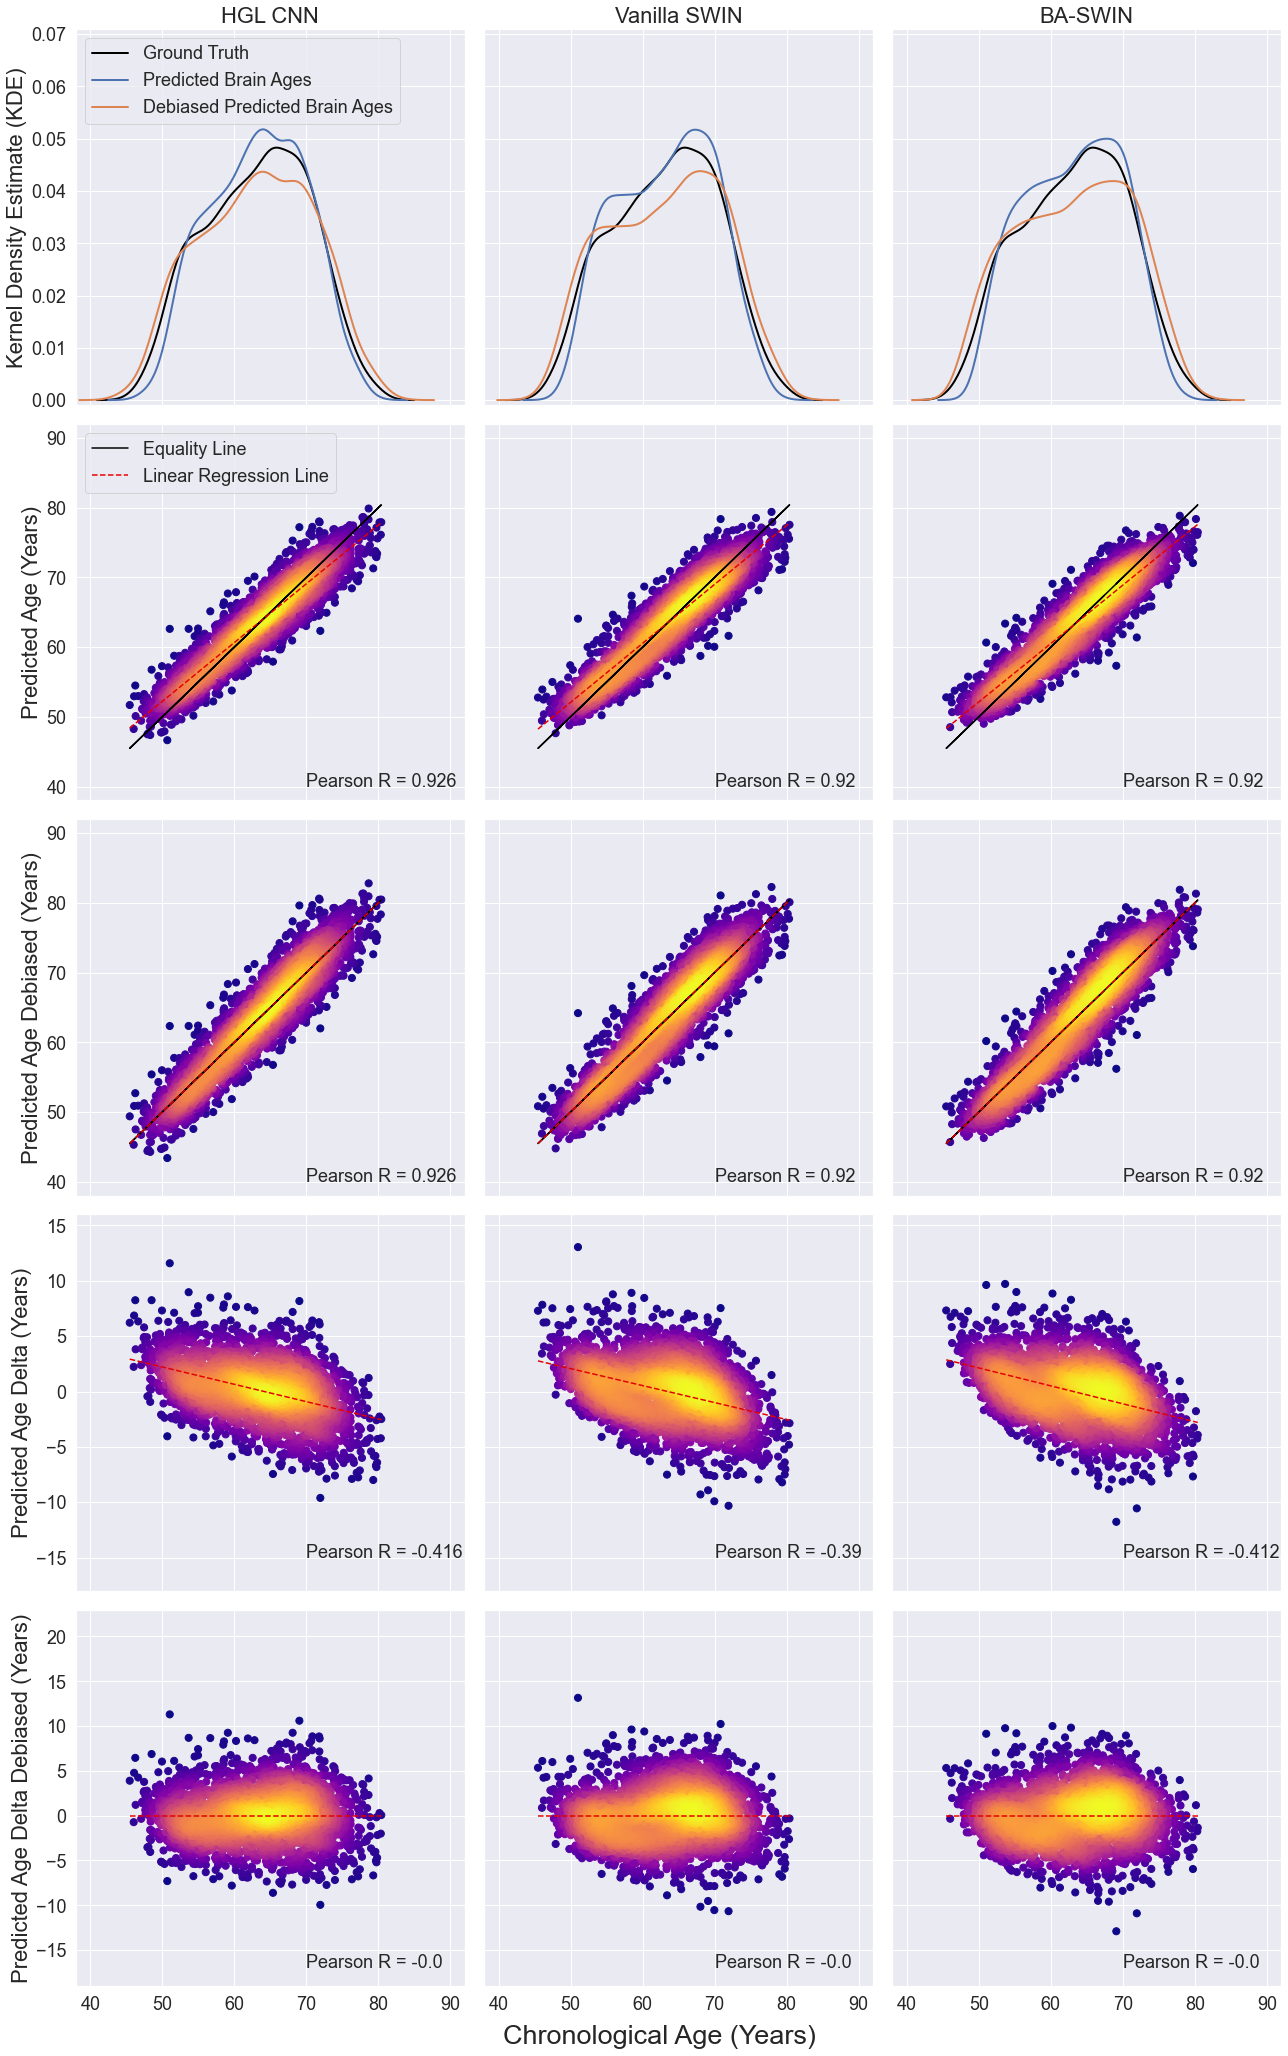

In [56]:
titles = [
    'HGL CNN',
    'Vanilla SWIN',
    'BA-SWIN'
]

legends = [
    'HGL CNN',
    'Vanilla SWIN',
    'BA-SWIN'
]

ncols=3
nrows=5
sz=7.2
title_font_size=22
ticks_font_size=18
legend_font = 18

fig, axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=(ncols*sz,nrows*sz))

# axes.set_xlabel('Chronological Age (Years)')

axes = axes.ravel()

i = 0

for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    if idx == 0:
        ylabel = 'Kernel Density Estimate (KDE)'
        x_axis_off_flag=True
        y_axis_off_flag=False
        plot_legend_flag = True
        plot_full_legend=True
    else:
        ylabel = None
        x_axis_off_flag=True
        y_axis_off_flag=True
        plot_legend_flag = False
        plot_full_legend=False
    
    kde_subplot(ax=axes[i], x=df_mod.target_age, y=[df_mod.mean_output_age, df_mod.output_age_decon],
                xlegend='Ground Truth', 
#                 ylegend=[legends[idx], legends[idx] + ' Debiased'],
                xlabel=None, ylabel=ylabel, title=titles[idx],
                set_hard_scale = [40,90,0,0.07],
               title_font_size=title_font_size,
               x_axis_off_flag=x_axis_off_flag, y_axis_off_flag=y_axis_off_flag,
                ticks_font_size = ticks_font_size,
                plot_legend_flag=plot_legend_flag, legend_font=legend_font
               )
    i+=1
    if idx == 3:
        break
    

for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    if idx == 0:
        ylabel = 'Predicted Age (Years)'
        x_axis_off_flag=True
        y_axis_off_flag=False
        plot_legend_flag = True
        plot_full_legend=True
    else:
        ylabel = None
        x_axis_off_flag=True
        y_axis_off_flag=True
        plot_legend_flag = False
        plot_full_legend=False
    scatter_plot_heatmap_subplots(ax=axes[i], x=df_mod.target_age, y=df_mod.mean_output_age, 
                                        xlabel=None, ylabel=ylabel, 
                                        title=None, set_scale=True,
                                  title_font_size=title_font_size, 
                                  set_hard_scale = [40,90,40,90],
                                  x_axis_off_flag=x_axis_off_flag, y_axis_off_flag=y_axis_off_flag,
                                  ticks_font_size = ticks_font_size,
                                  plot_legend_flag = plot_legend_flag, legend_font = legend_font, 
                                  plot_full_legend=plot_full_legend,
                                  text_x=70, text_y=40,
                                 )
    i+=1
    if idx == 3:
        break

for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    if idx == 0:
        ylabel = 'Predicted Age Debiased (Years)'
        x_axis_off_flag=True
        y_axis_off_flag=False
    else:
        ylabel = None
        x_axis_off_flag=True
        y_axis_off_flag=True
    scatter_plot_heatmap_subplots(ax=axes[i], x=df_mod.target_age, y=df_mod.output_age_decon, 
                                        xlabel=None, ylabel=ylabel, 
                                        title=None, set_scale=False,
                                        set_hard_scale = [40,90,40,90],
                                  title_font_size=title_font_size, 
                                  x_axis_off_flag=x_axis_off_flag, y_axis_off_flag=y_axis_off_flag,
                                  ticks_font_size = ticks_font_size,
                                  plot_legend_flag = False, legend_font = legend_font,
                                  text_x=70, text_y=40,
                                 )
    i+=1
    if idx == 3:
        break
    
for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    if idx == 0:
        ylabel = 'Predicted Age Delta (Years)'
        x_axis_off_flag=True
        y_axis_off_flag=False
    else:
        ylabel = None
        x_axis_off_flag=True
        y_axis_off_flag=True
    scatter_plot_heatmap_subplots(ax=axes[i], x=df_mod.target_age, y=df_mod.mean_age_delta, 
                                        xlabel=None, ylabel=ylabel, 
                                        title=None, set_scale=False, equality_line=False, 
#                                   set_y_scale=14,
                                  set_hard_scale = [40,90,-16,14],
                                 title_font_size=title_font_size, 
                                  x_axis_off_flag=x_axis_off_flag, y_axis_off_flag=y_axis_off_flag,
                                  ticks_font_size = ticks_font_size,
                                  plot_legend_flag = False, legend_font = legend_font,
                                  text_x=70, text_y=-15,
                                 )
    i+=1
    if idx == 3:
        break
        
    

for idx in range(len(df)):
    df_mod = df.iloc[idx].dataframe
    name_mod = df.iloc[idx].modality
    if idx == 0:
        ylabel = 'Predicted Age Delta Debiased (Years)'
        x_axis_off_flag=False
        y_axis_off_flag=False
    else:
        ylabel = None
        x_axis_off_flag=False
        y_axis_off_flag=True
    scatter_plot_heatmap_subplots(ax=axes[i], x=df_mod.target_age, y=df_mod.age_delta_decon, 
                                        xlabel=None, ylabel=ylabel, 
                                        title=None, set_scale=False, equality_line=False, 
#                                   set_y_scale=21,
                                  set_hard_scale = [40,90,-17,21],
                                  title_font_size=title_font_size, 
                                  x_axis_off_flag=x_axis_off_flag, y_axis_off_flag=y_axis_off_flag,
                                  ticks_font_size = ticks_font_size,
                                  plot_legend_flag = False, legend_font = legend_font, 
                                  text_x=70, text_y=-17,
                                 )
    i+=1
    if idx == 3:
        break
    


fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.supxlabel('Chronological Age (Years)', y=0.11, fontsize=title_font_size+5, verticalalignment='top')
    
# handles, labels = axes.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
# plt.figlegend( lines, labels, loc = 'lower center', ncol=5, labelspacing=0. )
# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labels)
    
fig.savefig('Scatter_Plots_FULL.png', bbox_inches='tight')
    